In [2]:
# Read in dataset to dataframe and split features and label
import pandas as pd
import numpy as np

# Please set the path to where the data set is stored
df = pd.read_csv("../Data/train.csv").sample(frac=1)
X = df.drop('Class', axis=1)
y = df['Class']

In [3]:
# Scale the two original features 'Amount' + 'Time' in dataframe
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, scale

# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()
# df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
# df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

X = df.drop('Class', axis=1)
y = df['Class']

In [4]:
# Split data into 80%/20% for train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

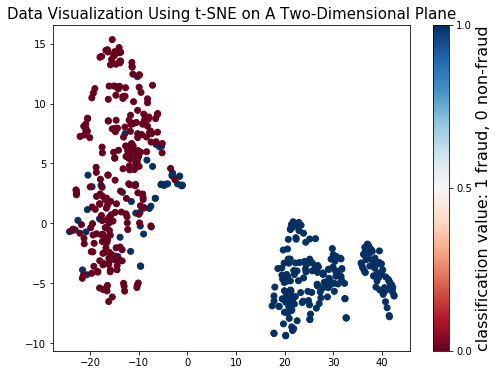

In [6]:
# Use t-SNE to visualize the high-dimensional data on a two-dimensional plane.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Divide the training data into two classes: fraud and non-fraud
fraud=X_train[y_train==1]
non_fraud=X_train[y_train==0]
cluster_ratio=fraud.shape[0]/non_fraud.shape[0]

# Reformulated the input data for TSNE
# Undersample the non-fraud class to get balanced data between fraud and non-fraud classes
non_fraud_selection=non_fraud[0:int(cluster_ratio*non_fraud.shape[0]),:]
Xtrain_input=np.concatenate((fraud, non_fraud_selection),axis=0)

# Create labels which will be used in the heatmap
labels=np.zeros((fraud.shape[0]+non_fraud_selection.shape[0]))
labels[0:fraud.shape[0]]=1

# Perform t-SNE on the randomly selected data
X_embedded=TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000).fit_transform(Xtrain_input)

# Make scatter plot to visualize data in 2-dimensional plane
plt.figure(figsize=(8,6))
points=plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='RdBu')
cbar=plt.colorbar(points, ticks=[0,0.5,1], orientation='vertical')
cbar.ax.set_ylabel('classification value: 1 fraud, 0 non-fraud', fontsize=16)
plt.title('Data Visualization Using t-SNE on A Two-Dimensional Plane', fontsize=15)
plt.savefig('t-SNE_Training.jpg')

In [7]:
# Grid search on N-neighbors with one fold of data
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# Optimize the model based on f1 socre 
# knn_grid = GridSearchCV(
#     estimator=KNeighborsClassifier(), 
#     param_grid={ 'n_neighbors': list(range(3, 10, 2)) }, 
#     scoring='f1',
#     cv=2, 
#     verbose=1, 
#     n_jobs=-1
# )

# Optimize the model based on auc_roc
knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid={ 'n_neighbors': list(range(3, 12, 2)) }, 
    scoring='roc_auc',
    cv=2, 
    verbose=1, 
    n_jobs=-1
)

pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority', random_state=5), knn_grid)
cut = int(len(y_train) * 0.8)
X_small = X_train[:cut]
y_small = y_train[:cut]
pipeline.fit(X_small, y_small)
knn_grid.best_params_

Using TensorFlow backend.


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.6min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


{'n_neighbors': 11}

In [8]:
# Train a KNN classifier with 5 fold cross validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Fine tunning parameter to find the best optimization
# algorithm 
knn = KNeighborsClassifier(n_neighbors=11, algorithm='auto', p=3)

cross_val_results = {
    'y_pred': [],
    'y_expect': [],
    'report': []
}

for train_index, test_index in StratifiedKFold(n_splits=5, random_state=5, shuffle=False).split(X_train, y_train):
    # Overfit with SMOTE during cross validation
    curr_X, curr_y = SMOTE(sampling_strategy='minority', random_state=5).fit_resample(X_train[train_index], y_train[train_index])
    knn.fit(curr_X, curr_y)
    
    y_pred = knn.predict(X_train[test_index])
    # Record current training result
    cross_val_results['y_pred'].append(y_pred)
    cross_val_results['y_expect'].append(y_train[test_index])
    cross_val_results['report'].append(classification_report(y_train[test_index], y_pred, output_dict=True))
    
    print('Finished one fold')

Finished one fold
Finished one fold
Finished one fold
Finished one fold
Finished one fold


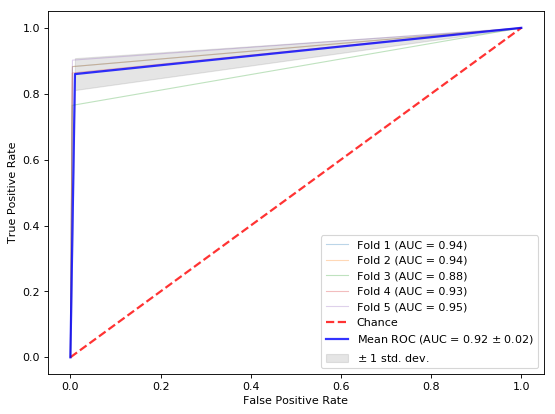

In [9]:
# Plot ROC curve for cross validation
from scipy import interp
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

for i in range(5):
    # Plot ROC curve for current fold
    fpr, tpr, thresholds = roc_curve(cross_val_results['y_expect'][i], cross_val_results['y_pred'][i])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='Fold %d (AUC = %0.2f)' % (i + 1, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('KNN_Train_AUC.jpg')
# plt.show()

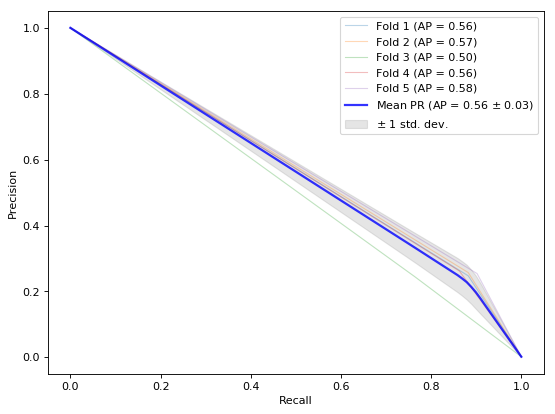

In [10]:
# Plot PR curve for cross validation
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

precisions = []
aps = []
mean_recall = np.linspace(0, 1, 100)

for i in range(5):
    # Plot PR curve for current fold
    precision, recall, _ = precision_recall_curve(cross_val_results['y_expect'][i], cross_val_results['y_pred'][i])
    precisions.append(interp(mean_recall, np.flip(recall), np.flip(precision)))
    ap = auc(recall, precision)
    aps.append(ap)
    plt.plot(recall, precision, lw=1, alpha=0.3, label='Fold %d (AP = %0.2f)' % (i + 1, ap))

mean_precision = np.mean(precisions, axis=0)
mean_ap = auc(mean_recall, mean_precision)
std_auc = np.std(aps)
plt.plot(mean_recall, mean_precision, color='b', label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_auc), lw=2, alpha=.8)

std_precision = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precision, 1)
precisions_lower = np.maximum(mean_precision - std_precision, 0)
plt.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('KNN_Train_PR.jpg')
# plt.show()

In [11]:
# Test the calssifier on the test data set which comes from train test split
# Comment out this part of code since we will use validation_under to test the model later.

# # Test the classifier with test dataset
# y_pred = knn.predict(X_test)
# # Print test report
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

In [12]:
# Print mean classification report for cross validation in training
cross_val_mean = { 
    '0': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 }, 
    '1': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
    'macro avg': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
    'weighted avg': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
}
accuracy = 0

for report in cross_val_results['report']:
    for class_label, metrics in report.items():
        if class_label not in cross_val_mean.keys() and class_label != 'accuracy':
            continue
        if class_label == 'accuracy':
            accuracy += metrics
            continue
        for metric, val in metrics.items():
            cross_val_mean[class_label][metric] += val
            
for class_label, metrics in cross_val_mean.items():
    print('Class:', class_label)
    for metric, val in metrics.items():
        print(metric, val / 5)
print(accuracy / 5)

Class: 0
precision 0.9997555097327927
recall 0.9956237359432535
f1-score 0.997685325346049
support 29568.6
Class: 1
precision 0.2528388025418412
recall 0.8588235294117647
f1-score 0.3905085275035739
support 51.0
Class: macro avg
precision 0.6262971561373168
recall 0.927223632677509
f1-score 0.6940969264248114
support 29619.6
Class: weighted avg
precision 0.9984694441365717
recall 0.9953881894022121
f1-score 0.9966398685967152
support 29619.6
0.9953881894022121


              precision    recall  f1-score   support

           0       0.89      0.98      0.93       173
           1       0.98      0.87      0.92       173

    accuracy                           0.93       346
   macro avg       0.93      0.93      0.93       346
weighted avg       0.93      0.93      0.93       346



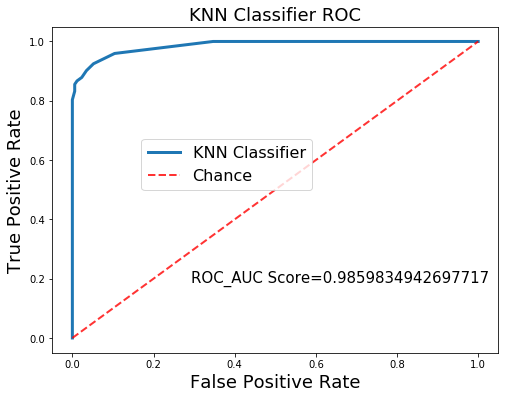

In [35]:
# Test on the undersampled validation set which has never been seen by the model 

test_dataframe = pd.read_csv("../Data/.csv").sample(frac=1)
test_dataframe['Amount'] = StandardScaler().fit_transform(test_dataframe['Amount'].values.reshape(-1,1))
Xtest = test_dataframe.drop('Class', axis=1)
Ytest = test_dataframe['Class']

Xtest=Xtest.values
Ytest=Ytest.values

YPrediction = knn.predict(Xtest)

# Print test report
print(classification_report(Ytest, YPrediction))

# Plot the roc_auc curve and precision recall curve
YResults=knn.predict_proba(Xtest)[:,1]
fpr, tpr, thresholds=roc_curve(Ytest, YResults)
roc=pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Thresholds': thresholds})
validation_auc=auc(fpr,tpr)

# precision, recall, _ = precision_recall_curve(Ytest, YResults)
# pr=pd.DataFrame({'Precision': precision, 'Recall': recall})

plt.figure(figsize=(8,6))
plt.plot(roc['FPR'], roc['TPR'], label='KNN Classifier', linewidth=3)
plt.xlabel('False Positive Rate', fontsize=18)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('KNN Classifier ROC', fontsize=18)
plt.plot([0,1], [0,1], linestyle='--', linewidth=2, color='red', label='Chance', alpha=0.8)
plt.text(0.66,0.2, r'ROC_AUC Score='+str(validation_auc), 
        {'color':'black', 'fontsize':15, 'ha':'center', 'va':'center'})
plt.legend(loc=[0.2, 0.5], fontsize=16)
plt.savefig('KNN_AUC.jpg')

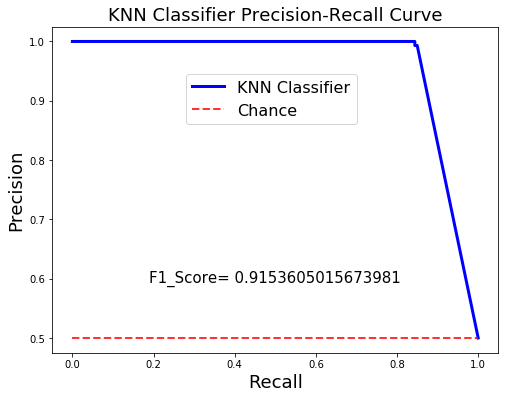

In [14]:
# Test the model on the validation data which the model has never seen; the validation sample is undersampled
# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(Ytest, YResults)
precision_curve=pd.DataFrame({'Precision': precision, 'Recall': recall})
validation_f1=f1_score(Ytest, YPrediction)

plt.figure(figsize=(8,6))
plt.plot(precision_curve['Recall'], precision_curve['Precision'], color='blue', 
         linewidth=3, label='KNN Classifier')
plt.plot([0,1], [0.5,0.5], linestyle='--', linewidth=2, color='red', label='Chance', alpha=0.8)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('KNN Classifier Precision-Recall Curve', fontsize=18)
plt.text(0.5, 0.6, r'F1_Score= '+str(validation_f1), 
        {'color':'black', 'fontsize':15, 'ha':'center', 'va':'center'})
# plt.fill_between(recall, 0, precision, color='red', alpha=0.3)
plt.legend(loc=[0.3, 0.7], fontsize=16)
plt.savefig('KNN_PR.jpg')

In [28]:
# Perform 5-fold cross-validation 
knn = KNeighborsClassifier(n_neighbors=11, algorithm='auto', p=3)

cross_val_results = {
    'y_pred': [],
    'y_expect': [],
    'report': []
}

for train_index, test_index in StratifiedKFold(n_splits=5, random_state=5, shuffle=False).split(Xtest, Ytest):
    # Overfit with SMOTE during cross validation
    # curr_X, curr_y = SMOTE(sampling_strategy='minority', random_state=5).fit_resample(X_train[train_index], y_train[train_index])
    curr_X=Xtest[train_index]
    curr_Y=Ytest[train_index]
    knn.fit(curr_X, curr_Y)
    
    y_pred = knn.predict(Xtest[test_index])
    print(y_pred.shape)
    # Record current training result
    cross_val_results['y_pred'].append(y_pred)
    cross_val_results['y_expect'].append(Ytest[test_index])
    cross_val_results['report'].append(classification_report(Ytest[test_index], y_pred, output_dict=True))
    
    print('Finished one fold')

(70,)
Finished one fold
(70,)
Finished one fold
(70,)
Finished one fold
(68,)
Finished one fold
(68,)
Finished one fold


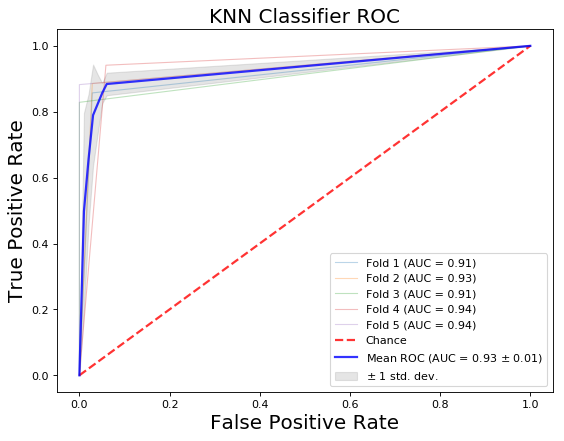

In [39]:
# Plot the 5-fold cross-validation AUC_ROC on the testing set
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

for i in range(5):
    # Plot ROC curve for current fold
    fpr, tpr, thresholds = roc_curve(cross_val_results['y_expect'][i], cross_val_results['y_pred'][i])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='Fold %d (AUC = %0.2f)' % (i + 1, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlabel('False Positive Rate', fontsize=18)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('KNN Classifier ROC', fontsize=18)
plt.legend(loc=[0.3, 0.7], fontsize=16)
plt.legend()
plt.savefig('KNN_Cross_Validation_AUC.jpg')
# plt.show()

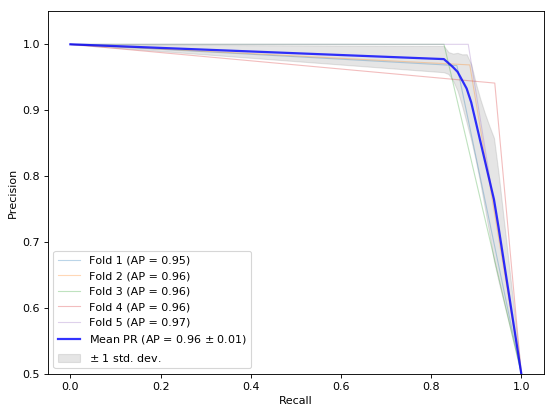

In [40]:
# Plot the 5-fold cross-validation precision-recall curve on the testing set
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

precisions = []
aps = []
mean_recall = np.linspace(0, 1, 100)

for i in range(5):
    # Plot PR curve for current fold
    precision, recall, _ = precision_recall_curve(cross_val_results['y_expect'][i], cross_val_results['y_pred'][i])
    precisions.append(interp(mean_recall, np.flip(recall), np.flip(precision)))
    ap = auc(recall, precision)
    aps.append(ap)
    plt.plot(recall, precision, lw=1, alpha=0.3, label='Fold %d (AP = %0.2f)' % (i + 1, ap))

mean_precision = np.mean(precisions, axis=0)
mean_ap = auc(mean_recall, mean_precision)
std_auc = np.std(aps)
plt.plot(mean_recall, mean_precision, color='b', label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_ap, std_auc), lw=2, alpha=.8)

std_precision = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precision, 1)
precisions_lower = np.maximum(mean_precision - std_precision, 0)
plt.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([0.5, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('KNN_Cross_Validation_PR.jpg')
# plt.show()

In [34]:
# Print mean classification report for cross validation on testing set
cross_val_mean = { 
    '0': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 }, 
    '1': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
    'macro avg': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
    'weighted avg': { 'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0 },
}
accuracy = 0

for report in cross_val_results['report']:
    for class_label, metrics in report.items():
        if class_label not in cross_val_mean.keys() and class_label != 'accuracy':
            continue
        if class_label == 'accuracy':
            accuracy += metrics
            continue
        for metric, val in metrics.items():
            cross_val_mean[class_label][metric] += val
            
for class_label, metrics in cross_val_mean.items():
    print('Class:', class_label)
    for metric, val in metrics.items():
        print(metric, val / 5)
print(accuracy / 5)

Class: 0
precision 0.8912207126357998
recall 0.9768067226890758
f1-score 0.931419862969123
support 34.6
Class: 1
precision 0.9755336812144213
recall 0.8789915966386556
f1-score 0.9238781028015005
support 34.6
Class: macro avg
precision 0.9333771969251107
recall 0.9278991596638656
f1-score 0.9276489828853117
support 69.2
Class: weighted avg
precision 0.9333771969251107
recall 0.9278991596638656
f1-score 0.9276489828853117
support 69.2
0.9278991596638656
